## Neural Network model (inflated data)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib
from sklearn.model_selection import cross_val_score

In [2]:
dataset = pd.read_csv('../dataset-processed/pre-processed-01.csv')
print("Numero di esempi: ", len(dataset))
dataset.head()

Numero di esempi:  11905


,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
0,0,0,52,0,0.000116,0.042888,1,0,0,0,1,0,0
1,0,0,44,0,0.000174,0.057932,1,0,1,0,0,0,0
2,2,4,16,1,0.000044,0.019899,1,0,0,1,0,0,0
3,0,0,1,1,0.000256,0.042174,1,0,1,0,0,0,0
4,0,1,26,0,0.000099,0.042953,1,1,0,0,0,0,0


### Caratteristiche iniziati del dataset

In [3]:
dataset['target'].value_counts()

1    11645
0      260
Name: target, dtype: int64

In [4]:
X = dataset.drop(labels=['target'], axis = 1)
y = dataset['target']

In [5]:
X.head(2)

,hashtag,tag,caption,is_video,n_comment,n_likes,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
0,0,0,52,0,0.000116,0.042888,0,0,0,1,0,0
1,0,0,44,0,0.000174,0.057932,0,1,0,0,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [7]:
X_test_pandas = X_test

In [8]:
X_test.head(2)

,hashtag,tag,caption,is_video,n_comment,n_likes,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
6212,0,2,8,1,0.000044,0.004897,0,0,0,0,0,0
11010,0,0,21,1,0.000487,0.025287,0,0,0,1,0,0


In [9]:
# z-score
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Inflate minority class

"By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable. Let’s see if that’s true."

Classi:
- paid = 0
- standard = 1

In [10]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [11]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
X_train.shape, y_train.shape

((18632, 12), (18632,))

In [12]:
print('Esempi training standard: ', sum(y_train == 1))
print('Esempi training paid: ', len(X_train) - sum((y_train == 0)))

Esempi training standard:  9316
Esempi training paid:  9316


In [13]:
print('Esempi test standard: ', sum(y_test == 1))
print('Esempi test paid: ', sum(y_test == 0))

Esempi test standard:  2329
Esempi test paid:  52


### Neural network model

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
print(tf.__version__)

2.1.0


In [15]:
def create_model():
    model = Sequential()
    model.add(Dense(X.shape[1], activation="relu", input_dim = X.shape[1]))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
model = create_model()
history = model.fit(X_train, y_train, batch_size = 10, epochs = 10, verbose = 1)

Train on 18632 samples
Epoch 1/10
18632/18632 [==============================] - 4s 213us/sample - loss: 0.3983 - accuracy: 0.8141
Epoch 2/10
18632/18632 [==============================] - 4s 194us/sample - loss: 0.2685 - accuracy: 0.8928
Epoch 3/10
18632/18632 [==============================] - 4s 196us/sample - loss: 0.2312 - accuracy: 0.9109
Epoch 4/10
18632/18632 [==============================] - 4s 196us/sample - loss: 0.2068 - accuracy: 0.9240
Epoch 5/10
18632/18632 [==============================] - 4s 195us/sample - loss: 0.1920 - accuracy: 0.9293
Epoch 6/10
18632/18632 [==============================] - 4s 203us/sample - loss: 0.1798 - accuracy: 0.9351
Epoch 7/10
18632/18632 [==============================] - 4s 205us/sample - loss: 0.1698 - accuracy: 0.9382
Epoch 8/10
18632/18632 [==============================] - 4s 197us/sample - loss: 0.1583 - accuracy: 0.9438
Epoch 9/10
18632/18632 [==============================] - 4s 196us/sample - loss: 0.1545 - accuracy: 0.9447
Epoch

### Evaluate the model

In [17]:
y_pred = model.predict_classes(X_test)
accuracy_score(y_test, y_pred)

0.9143217135657287

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1413e0748>)

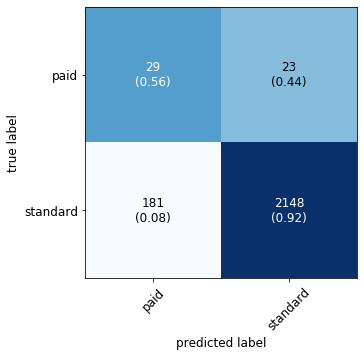

In [18]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.56      0.22        52
           1       0.99      0.92      0.95      2329

    accuracy                           0.91      2381
   macro avg       0.56      0.74      0.59      2381
weighted avg       0.97      0.91      0.94      2381



### Considerazioni sui risultati ottenuti

In [20]:
df = pd.read_csv('../dataset/influencer_dataset.csv')
X_test = X_test_pandas

##### Valutazione dei F_paid (False Paid)

In [21]:
false_paid = X_test[(y_test == 1) & (y_pred[:,0].T == 0)]
print(len(false_paid))
F_paid_index = false_paid.index.to_list()
F_paid_index[:5]

181


[8345, 10825, 9979, 6695, 981]

In [22]:
df.loc[F_paid_index].head()

,index,username,photo_id,followed_by,hashtag,tag,caption,is_video,timestamp,n_comment,n_likes,target
8345,4,taylorswift,taylorswift4,127156663,['#MissAmericana'],"['@netflixfilm', '@lanawilson']",So it’s finally out is on and I’m really excit...,False,1580475734,0,1506117,standard
10825,0,paollaoliveirareal,paollaoliveirareal0,24801482,['#AmeSemModeração'],['@useamedigital.'],Eu amei essa cabeça feita pela Trazendo o colo...,False,1582386747,245,51204,standard
9979,6,annehathaway,annehathaway6,16725022,['#DarkWaters'],"['@markruffalo,', '@Observer.']",I know my posting this will make you cringe so...,False,1574448596,253,113770,standard
6695,10,sonamkapoor,NaN,25645813,"['#LAtheKapoorWay', '#discoverLA']","['@aviatornation', '@RheaKapoor', '@discoverLA']",Shopping has always been my guilty pleasure an...,True,1581595286,322,49037,standard
981,983,ayeshacurry,ayeshacurry11,7199502,"['#exhibitionistmascara', '#ExhibitionistMasca...",['@covergirl'],NEW DROP 🚨 alert Check out my new commerial We...,False,1581442665,704,119217,standard


##### Valutazione dei T_paid (True Paid)

In [23]:
true_paid = X_test[(y_test == 0) & (y_pred[:,0].T == 0)]
print(len(true_paid))
T_paid_index = true_paid.index.to_list()
T_paid_index[:5]

29


[8087, 2680, 11064, 9791, 3512]

In [24]:
df.loc[T_paid_index].head()

,index,username,photo_id,followed_by,hashtag,tag,caption,is_video,timestamp,n_comment,n_likes,target
8087,10,amandaeliselee,NaN,12070273,"['#BangEnergy', '#EnergyDrink', '#Redline']","['@Redline_Energy', '@BangEnergy.CEO']",Today’s HIIT workout fueled by princess 💕 I’ve...,True,1576783307,787,51161,paid
2680,2709,garethbale11,garethbale119,42936370,"['#Supercourt', '#HomeofClassics']",['@adidasoriginals'],👌🏼👟🔥,False,1572520154,3386,671935,paid
11064,11,adamlevine,adamlevine11,12463730,"['#YSLbeauty', '#thatsY']",['@yslbeauty'],Y Live Yves Saint Laurent,False,1575046851,4301,544137,paid
9791,10,viihtube,NaN,13910782,"['#TikTokFolia', '#TikTokFolia', '#Ad']",['@tiktokbrasil'],O que eu tentei explicar nesse vídeo foi sobre...,True,1581520053,488,168876,standard
3512,3547,hazardeden_10,hazardeden_107,26684701,"['#TOTY', '#FIFA20']",['@EASPORTSFIFA'],‪My friends Its great to be nominated please c...,False,1576231737,4276,659524,paid


##### Valutazione dei F_standard (False Standard)

In [25]:
false_standard = X_test[(y_test == 0) & (y_pred[:,0].T == 1)]
print(len(false_standard))
F_standard_index = false_standard.index.to_list()
F_standard_index[:5]

23


[10430, 9267, 8265, 3661, 9233]

In [26]:
df.loc[F_standard_index].head()

,index,username,photo_id,followed_by,hashtag,tag,caption,is_video,timestamp,n_comment,n_likes,target
10430,1,brooklynbeckham,NaN,11996602,"['#Thei8', '#racingbeyond', '#ad']","['@BMWMotorsport', '@BMWi']",Wrapping up an amazing week in Mexico City Got...,True,1582062946,111,31907,paid
9267,2,stevengerrard,stevengerrard2,8630960,"['#stevengerrardliveoslo', '#ad', '#stevengerr...",['@oslokonserthus'],Looking forward to meeting everyone in Norway ...,False,1582282664,539,96044,standard
8265,8,claireholt,claireholt8,5120153,"['#AvaPartner', '#ClairexAva']","['@avawomen', '@avawomen.', '@redcrossau', '@w...",I’ve been traveling a lot the last few months ...,False,1579711536,472,232194,paid
3661,3696,alvaroricoladera,alvaroricoladera0,3709011,"['#thefurlasociety', '#adv', '#furlaillusions']",['@furla'],Gracias It was a pleasure 🇮🇹 🤟🏻,False,1582227741,897,298351,standard
9233,4,anllela_sagra,NaN,11504533,"['#CandyAppleCrisp', '#BangEnergy', '#energydr...","['@BangEnergy', '@BangEnergy.CEO', '@Megliz.Sw...",Sooo delicious So WILD 🍬🍏Totally in LOVE with ...,True,1581873238,341,38384,paid
